# desc-wfmon/monexp.ipynb: Monitor explorer example

We use the classes in desc-wfmon to view monitoring data from DESC gen3 parsl jobs.  

First setup to use the local install area and then import the the system (sysmon) and process (wfmon) explorers. 

See desc-wfmon/install.ipynb to install that package in the local directory and create the setup on the first line. 

In [1]:
%run install/setup.py
import sys
print(f"Python version is {sys.version}")
print(f"Python search path starts with {sys.path[0]}:{sys.path[1]}:{sys.path[2]}")
!pwd
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import desc.wfmon
import desc.sysmon
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")

Python version is 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python search path starts with ./install/noconda:/global/u2/d/dladams/desc/dev/desc-wfmon/ipynb:
/global/u2/d/dladams/desc/dev/desc-wfmon/ipynb
<module 'desc.wfmon' from '/global/u2/d/dladams/desc/dev/desc-wfmon/ipynb/./install/noconda/desc/wfmon/__init__.py'> version is 0.0.14.dev1
<module 'desc.sysmon' from '/global/u2/d/dladams/desc/dev/desc-wfmon/ipynb/./install/noconda/desc/sysmon/__init__.py'> version is 0.0.14.dev1


## Configuration
Define some useful constants and specify the location of the monitoring data files. Set dir to point to your area.

In [2]:
minute = 60
hour = 3600
day = 24*hour
tunit = minute
stunit = 'minute'

mb = 2**20
gb = 2**30
bunit = gb
bunit_sys = bunit/gb
sbunit = 'GB'

snjob = '60'
suffix = ''
#suffix = '-noshuffle'
dir = f"/global/homes/d/dladams/desc/parsltest/scan01/runinfo-{snjob}-300-{snjob}-1-1.8{suffix}/"
dir = f"/global/homes/d/dladams/desc/parsltest/runinfo-200-300-{snjob}-1-1.8{suffix}/"
#dir = '/global/homes/d/dladams/desc/parsltest/runinfo/'
dir = f"/global/homes/d/dladams/desc/test8/"
dirProc = dir
if 0:
    dir = f"/global/homes/d/dladams/desc/test9/"
    dirProc = dir + 'runinfo/'
line = '-----------------------------------------------------------'

## Fetch system-level monitoring data

System level monitoring data is collected using *desc.sysmon*. The data is in csv format and is read here with *pandas*.

The column names follow from those of the corresponding *psutil* variables.

We fetch the number of CPUs and total memory and check both are consistent for all samples.

In [3]:
sym = pandas.read_csv(dir + 'sysmon.csv')
print(f"System monitor sample count: {len(sym)}")
print(f"System monitor columns:")
for cnam in sym.columns:
    print(f"  {cnam}")

assert(len(sym.cpu_count.unique()) == 1)
ncpu = sym.cpu_count[0]
print(f"CPU count is {ncpu:.0f}")

assert(len(sym.mem_total.unique()) == 1)
maxmem = sym.mem_total[0]/bunit_sys
print(f"Total memory is {maxmem:.1f} {sbunit}")


System monitor sample count: 619
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 64
Total memory is 125.8 GB


## Fetch the process-level monitoring data

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

We "fix" that data to make it more amenable for analysis. Among many other modifications, fixing converts time strings to integers and add a procsum (process summary) table which sums the contributions from all jobs. Although the sampling interval is the same for all jobs, they have different offsets and so there is some ambiguity in this summing.

For disk and network I/O, integrated values are recorded but the differential values (the amount read or written each sampling interval) are of interest here. A separate call is made to build a procsum table that includes these differential values. This is not done automatically because it can be slow.

In [4]:
dbr = desc.wfmon.MonDbReader(dirProc + 'monitoring.db', dodelta=True)
print(line)
dbr.tables(2)

-----------------------------------------------------------
DB /global/homes/d/dladams/desc/test8/monitoring.db has 9 tables
*******************************************************
Table workflow has 1 rows and 9 columns
Column names:
     int64   run_idx
     int64   wf_idx
   float64   time_began
    object   time_completed
    object   host
    object   user
    object   rundir
     int64   tasks_failed_count
     int64   tasks_completed_count
*******************************************************
Table task has 2158 rows and 15 columns
Column names:
     int64   task_id
     int64   run_idx
    object   task_depends
     int64   task_idx
    object   task_memoize
    object   task_hashsum
    object   task_inputs
    object   task_outputs
    object   task_stdin
    object   task_stdout
    object   task_stderr
   float64   task_time_invoked
   float64   task_time_returned
     int64   task_fail_count
   float64   task_fail_cost
****************************************************

## Run selection
Define handles for the process tables of interest:

* prc - Process table holds sampled data for each process
* psm - Process summary table (procsum) holds samples summed over all processes

If the process monitor includes more than one run, then select one run to study here.

In [5]:
nrun = len(dbr.table('workflow'))
if nrun == 1:
    print('One run found.')
    prc = dbr.table('resource')
    psm = dbr.table('procsum')
else:
    rqry = 'run_idx==0'
    print("Selecting runs with {rqry}")
    prc = dbr.table('resource').query(rqry)
    psm = dbr.table('procsum').query(rqry)
print(f"Process table entry count: {len(prc)}")
print(f"Procsum table entry count: {len(psm)}")
print(f" System table entry count: {len(sym)}")

One run found.
Process table entry count: 3229
Procsum table entry count: 46
 System table entry count: 619


## Time range

For convenience we add a column tfix to each table that converts to units defined above.  
The time offset used in the process tables is applied to the system table.

In [6]:
t0sec = dbr.t0
delt = dbr.monitoring_interval
deltsys = (max(sym.time) - min(sym.time))/float(len(sym) - 1)

prc['tfix'] = prc.timestamp/tunit
psm['tfix'] = psm.timestamp/tunit
sym['tfix'] = (sym.time - t0sec)/tunit

tprc1 = prc.timestamp.min()/tunit
tprc2 = prc.timestamp.max()/tunit
tpsm1 = psm.timestamp.min()/tunit
tpsm2 = psm.timestamp.max()/tunit
tsym1 = psm.timestamp.min()/tunit
tsym2 = psm.timestamp.max()/tunit
tmin = 0.0
tmax = 1.01*tsym2

print(f"  Proc time interval: {delt:.2f}")
print(f"   Sys time interval: {deltsys:.2f}")
print(f" Process time range: ({tprc1:.2f}, {tprc2:.2f}) {stunit}")
print(f" Procsum time range: ({tpsm1:.2f}, {tpsm2:.2f}) {stunit}")
print(f"  System time range: ({tsym1:.2f}, {tsym2:.2f}) {stunit}")
print(f"Plotting time range: ({ tmin:.2f}, { tmax:.2f}) {stunit}")

  Proc time interval: 60.00
   Sys time interval: 5.01
 Process time range: (0.23, 46.56) minute
 Procsum time range: (0.50, 45.50) minute
  System time range: (0.50, 45.50) minute
Plotting time range: (0.00, 45.95) minute


## Tasks
We look at the task types, how many of each were run and plot the distribution of run times for the tasks.

2680.4357159137726
         Task count: 2158
     Task idx count: 9
  Unique task count: 2158
          Try count: 2158
     Try done count: 1995

Task name [done/count]
   0: isr [391/392]
   1: characterizeImage [374/392]
   2: calibrate [357/392]
   3: writeSourceTable [354/392]
   4: transformSourceTable [351/392]
   5: consolidateSourceTable [83/98]
   6: consolidateVisitSummary [85/98]
   7: makeCcdVisitTable [0/1]
   8: makeVisitTable [0/1]


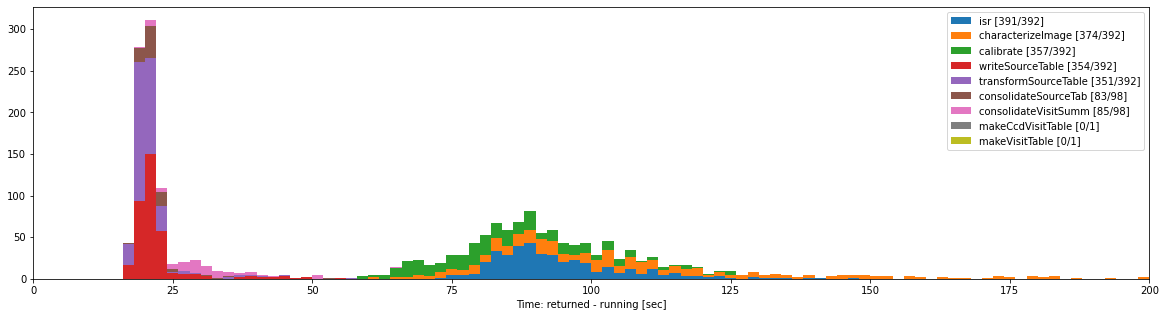

In [7]:
tsk = dbr.table('task')
tsy = dbr.table('try')
print((tsy.task_try_time_running - tsy.task_try_time_launched).dropna().max())
tsyDone = tsy.query("task_try_time_returned==task_try_time_returned")
print(f"         Task count: {len(tsk)}")
print(f"     Task idx count: {len(tsk.task_idx.unique())}")
print(f"  Unique task count: {len(tsk.task_id.unique())}")
print(f"          Try count: {len(tsy)}")
print(f"     Try done count: {len(tsyDone)}")

print()
print("Task name [done/count]")
ntsk = len(dbr.task_names)
tsyDoneByTask = [None]*ntsk
for itsk in range(ntsk):
    tsyDoneByTask[itsk] = tsyDone.query(f"task_idx=={itsk}")
    print(f"{itsk:4}: {dbr.task_names[itsk]} [{len(tsyDoneByTask[itsk])}/{dbr.task_name_counts[itsk]}]")

pdx = 20
pdy = 5
x1 = 0
x2 = 200
# Fetch run times for each type of task
taskdts = [None]*ntsk
cols = [None]*ntsk
ncol = len(cols)
labs = [None]*ntsk
#mycols = ['red', 'green', 'orange', 'blue', 'yellow', 'violet', 'cyan', 'pink']
for itsk in range(ntsk):
    t1 = tsyDoneByTask[itsk].task_try_time_running
    t2 = tsyDoneByTask[itsk].task_try_time_returned
    taskdts[itsk] = (t2-t1).clip(upper=0.999*x2)
    #cols[itsk] = 'tab:' + mycols[itsk%8]
    labs[itsk] = f"{dbr.task_names[itsk][0:20]} [{len(tsyDoneByTask[itsk])}/{dbr.task_name_counts[itsk]}]"
    #print(f"Color {cols[itsk]}")
plt.figure(figsize=(pdx, pdy))
plt.hist(bins=100, range=(x1, x2), x=taskdts, stacked=True, label=labs)
plt.legend(loc="upper right")
plt.xlabel('Time: returned - running [sec]')
junk = plt.xlim([x1, x2])

## Task states
Next look at when the tasks enter eacof the three try states: launched, running and returned.  

The figure shows the (integrated) number of tasks completed as function of time for each task type.

       time    0    1    2    3    4   5   6  7  8   all       tfix
0       0.0    0    0    0    0    0   0   0  0  0     0   0.000000
1      10.0    0    0    0    0    0   0   0  0  0     0   0.166667
2      20.0    0    0    0    0    0   0   0  0  0     0   0.333333
3      30.0    0    0    0    0    0   0   0  0  0     0   0.500000
4      40.0    0    0    0    0    0   0   0  0  0     0   0.666667
..      ...  ...  ...  ...  ...  ...  ..  .. .. ..   ...        ...
275  2750.0  390  369  353  346  342  83  84  0  0  1967  45.833333
276  2760.0  391  372  354  351  344  83  84  0  0  1979  46.000000
277  2770.0  391  373  354  353  344  83  84  0  0  1982  46.166667
278  2780.0  391  373  354  353  346  83  84  0  0  1984  46.333333
279  2790.0  391  373  356  354  350  83  85  0  0  1992  46.500000

[280 rows x 12 columns]


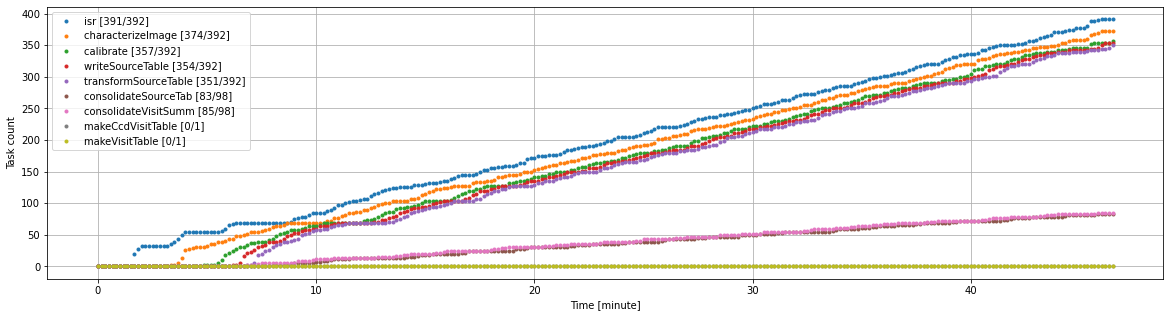

In [8]:
dbr.taskcounts(delt=10)
for dfs in dbr._taskcounts:
    for idf in dfs:
        dfs[idf]['tfix'] = dfs[idf].time/tunit
dbr._taskcounts[0]['running']
print(dbr.taskcounts('returned', 0))
plt.figure(figsize=(pdx, pdy))
state = 'running'
tsclau = dbr.taskcounts('launched')
tscrun = dbr.taskcounts('running')
tscret = dbr.taskcounts('returned')
for itsk in range(ntsk):
    plt.plot(tscret.tfix, tscret[itsk], '.', color=cols[itsk%ncol], label=labs[itsk])
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Task count')
plt.legend()
plt.grid(True)
#junk = plt.axis([0, 2800,0, 400])

This figure shows the total number of jobs launched, started and finished as function of time

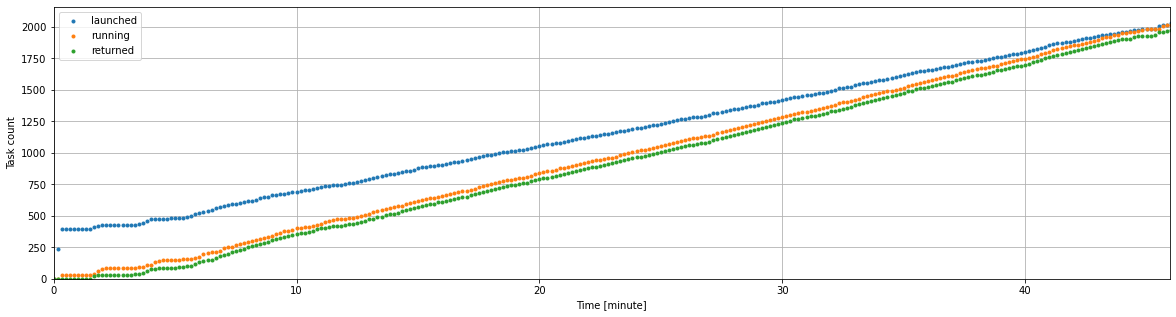

In [9]:
plt.figure(figsize=(pdx, pdy))
plt.plot(tscrun.tfix, tsclau['all'], '.', color=cols[0], label='launched')
plt.plot(tscrun.tfix, tscrun['all'], '.', color=cols[1], label='running')
plt.plot(tscrun.tfix, tscret['all'], '.', color=cols[2], label='returned')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Task count')
plt.legend()
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, len(tsy)])

## Running jobs

We would like to know how many tasks were running as function of time.

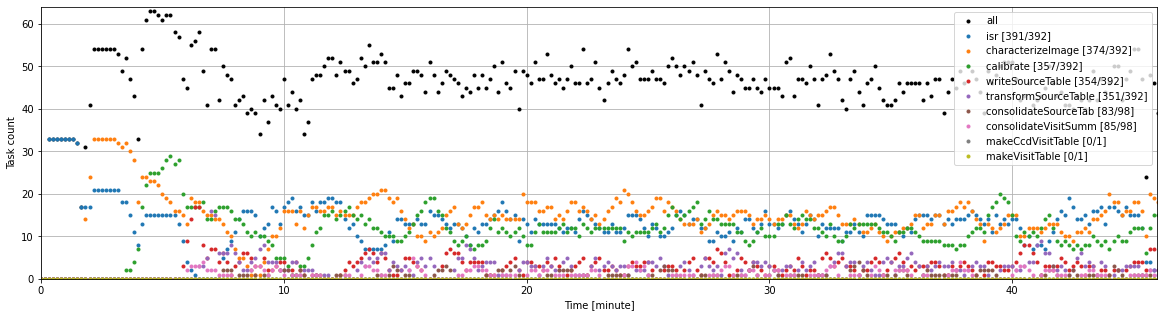

In [10]:
plt.figure(figsize=(pdx, pdy))
plt.plot(tscrun.tfix, tscrun['all'] - tscret['all'], '.', color='black', label='all')
for itsk in range(ntsk):
    plt.plot(tscret.tfix, tscrun[itsk] - tscret[itsk], '.', color=cols[itsk%ncol], label=labs[itsk])
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Task count')
plt.legend()
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, 64])

## CPU efficiency

The system monitor records the total CPU time and that in varioys

Procsum provides many estimates of the number of running processes. The counter *nval* holds the number of process entries contributing to each summed sample and *nproc* holds the number of unique process IDs contributing to each sum. These can (rarely?) differ because of jitter in the process sampling times but, more significantly, the process monitior includes an extra sampling at the end of the job which comes in out of phase and may be collected in same sum as the preceding sample. These values are shown as a function of time as lines (*nval* in green and *nproc* in red) in the following plot.

The process monitor also records (and procsum sums) the total CPU time and the CPU time spent in two states: *user* (executing user code) and *system* (performing system operations such as I/O on behalf of the user. The sum of these (*user*+*system*) and *user* alone divided by the total time are shown on the plot with markers.

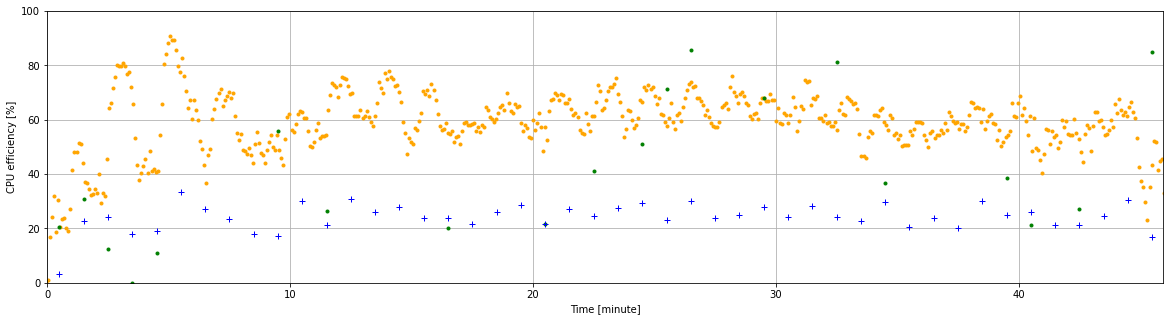

In [11]:
plt.figure(figsize=(pdx, pdy))
plt.plot(sym.tfix, sym.cpu_percent, '.', color='orange')
plt.plot(psm.tfix, psm.procsum_cpu_percent, '.', color='green')
##plt.plot(psm.tfix, psm.nval, 'g--')
#plt.plot(psm.tfix, psm.nproc, 'r--')
plt.plot(psm.tfix, (psm.procsum_time_user+psm.procsum_time_system)/delt, 'b+')
#plt.plot(psm.tfix, psm.procsum_time_user/delt, 'cx')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU efficiency [%]')
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, 100])

## Memory usage

Frame sizes: 619 46 46, 46


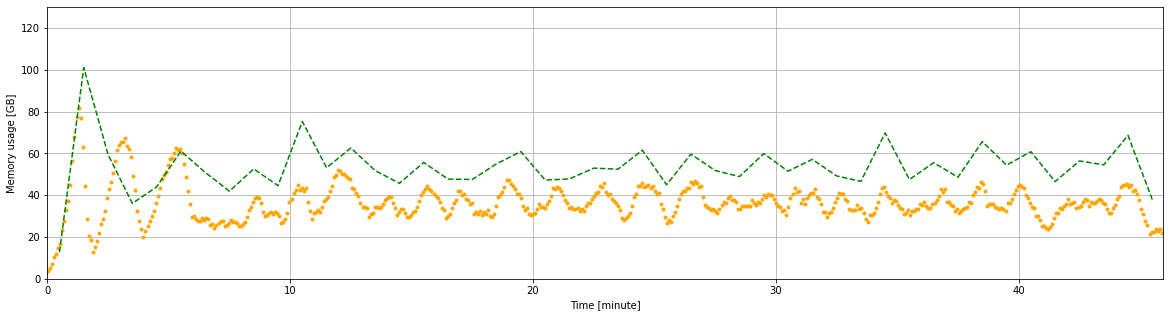

In [12]:
plt.figure(figsize=(pdx, pdy))
plt.plot(sym.tfix, (sym.mem_total - sym.mem_available)/bunit_sys, '.', color='orange')
plt.plot(psm.tfix, psm.procsum_memory_resident/gb, 'g--')
ntim = min(len(sym), len(psm))
diff = (sym.mem_total - sym.mem_available).iloc[0:ntim]/bunit_sys - psm.procsum_memory_resident.iloc[0:ntim]/gb
print(f"Frame sizes: {len(sym)} {len(psm)} {ntim}, {len(diff)}")
plt.plot(sym.tfix.iloc[0:ntim], diff[0:ntim], '-', color='gray')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Memory usage [GB]')
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, 130])

## I/O rates

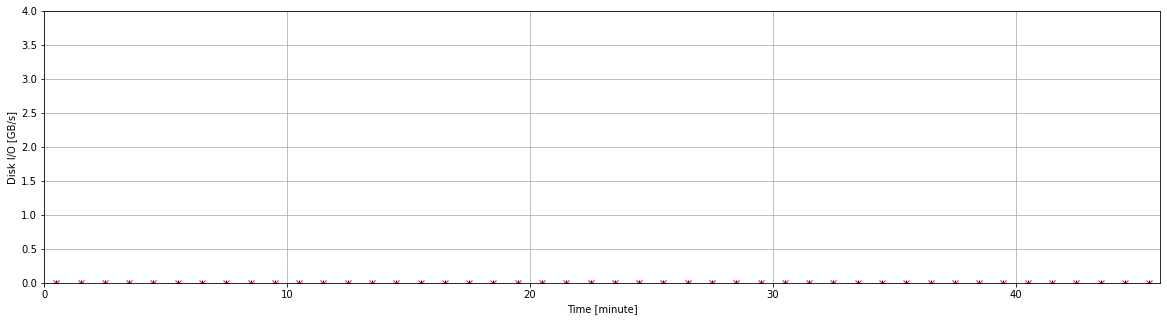

/global/u2/d/dladams/desc/dev/desc-wfmon/ipynb


NameError: name 'savefig' is not defined

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(pdx, pdy))
plt.plot(psm.tfix, psm.procsum_disk_read/gb/delt, 'b+')
plt.plot(psm.tfix, psm.procsum_disk_write/gb/delt, 'rx')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Disk I/O [GB/s]')
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, 4])
plt.show()
plt.savefig('io.png')
!pwd
savefig('io2.png')
!ls -ls io*